Автор:<br>Коваленко А.О.<br>Студент 2 курса магистратуры кафедры "ИУ3" МГТУ им. Н.Э. Баумана<br>

##### Ячейка под импорты модулей

In [ ]:
%matplotlib inline
from model import DCGAN
import rcnn
import tensorflow as tf

from PIL import Image
from matplotlib.pyplot import imshow
from glob import glob
import numpy as np
import random
import utils
import os
import scipy.misc
data_dir = './data'


## 1 Обучающая выборка сотавленная из нарезанных на более мелкие изображения эталонных паттернов

Данная обучающая выборка основана на паттернах камуфляжей:
* Marpat
* Cadpat
* Флора
* Спектр СКВО
* Multicam
* Flecktarn
* Растр

Данный блок кода преобразует эталонные изображения паттернов камуфляжей к одинаковому формату и размеру для дальнейшей нарезки на более мелкие изображения, которые и будут составлять обучающую выборку.

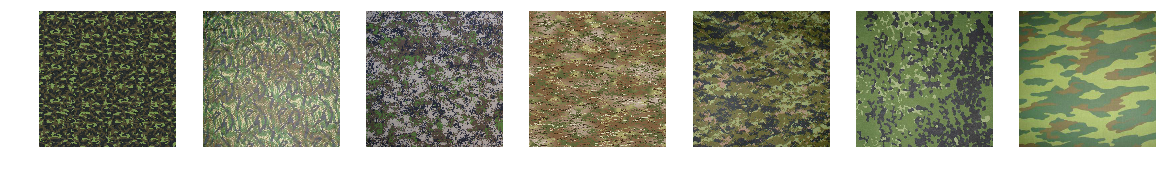

In [7]:
#Получаем список файловых путей к изображениям  
image_paths_list = glob(os.path.join(data_dir, 'camo_samples/test2/[0-9].*g'))

#Преобразуем изображения и сохраняем
img_number = 0
for image_path in image_paths_list:
    image = Image.open(image_path)
    
    image = image.crop([0, 0, min(image.size[0],image.size[1]), min(image.size[0],image.size[1])])
    image = image.resize([1000, 1000], Image.BILINEAR)
    
    rgb_im = image.convert('RGB')
    rgb_im.save(data_dir + '/camo_patterns/test2/' + str(img_number) + '.jpg')
    img_number+=1
#Покажем получившиестя паттерны
utils.show_images_fullsize(image_paths=glob(os.path.join(data_dir, 'camo_patterns/test2/[0-9].*g')),columns=7)

Данный блок кода формирует обучающую выборку из паттернов камуфляжей, полученных в предыдущем пункте. Элемент обучающей выборки получается вырезанием изображения размером 150x150 со случайными координатами из исходного паттерна камуфляжа, а затем сжатием его до размера 64x64 для ускорения обучения нейронной сети. Из каждого паттерна вырезаеся по 1000 более мелких изображений, формируя выборку общим размером в 7000 изображений.

In [13]:
#Получаем список файловых путей паттернов камуфляжей
pattern_dir = image_paths_list = glob(os.path.join(data_dir, 'camo_patterns/test2/[0-9].jpg'))

#Задаем параметры формирования элемента обучающей выборки
samples_per_pattern = 1000
crop_width = 150
crop_height = 150
resize_width = 64
resize_height = 64

#Формируем обучающую выборку
img_number = 0
for pattern_path in pattern_dir:
    pattern = Image.open(pattern_path)    
    for i in range(0,samples_per_pattern):
        #Получаем случайные координаты на паттерне
        x_offset = random.randint(0,pattern.size[0] - crop_width)
        y_offset = random.randint(0,pattern.size[1] - crop_height)
        #Вырезаем элемент размером crop_width x crop_height
        sample = pattern.crop([0 + x_offset,0 + y_offset, crop_width + x_offset, crop_height + y_offset])
        #Изменяем его размер на resize_width x resize_height
        sample = sample.resize([resize_width,resize_height], Image.BILINEAR)
        sample.save(data_dir + '/camoflage_test2/' + str(img_number) + '.jpg', mode='RGB')
        img_number+=1

Примеры изображений обучающей выборки:

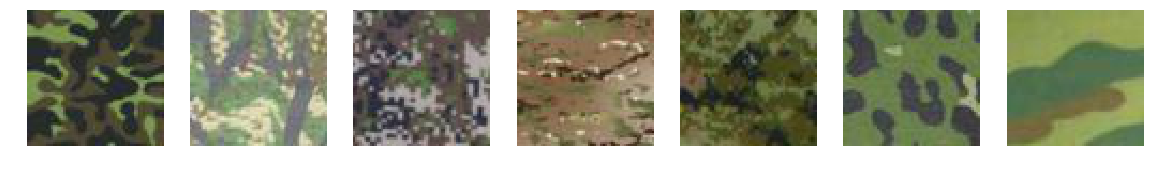

In [15]:
utils.show_images_fullsize(image_paths=[data_dir+'/camoflage_test2/'+str(i)+'.jpg' for i in range(0,6001,1000)],columns=7)

## 2.  Обучение DCGAN

### 2.1  Создание модели DCGAN в фреймворке Tensorflow

Модель DCGAN описана в:

>*Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks.
Alec Radford, Luke Metz, Soumith Chintala. ICLR 2016.* [Arxiv 2016](https://arxiv.org/abs/1511.06434).

Программная реализация DCGAN выполнена в фреймворке tensorflow и основана на:<br>
https://github.com/carpedm20/DCGAN-tensorflow<br>

Краткое описание основной идеи архитектуры DCGAN на основе двух нейронных сетей:

1. Создается две модели, одна — генеративная (назовем ее создателем подделок), и вторая — дискриминативная (эта пусть будет экспертом)
2. Создатель подделок пытается построить на выходе фальшивку, а эксперт — отличить фальшивку от оригинала (обе модели начинают с рандомных условий, и поначалу выдают в качестве результатов шум и мусор).
3. Цель создателя подделок — сделать такой продукт, который эксперт не мог бы отличить от настоящего. Цель эксперта — максимально эффективно отличать фальшивки от оригиналов. Обе модели начинают игру друг против друга, где останется только один.

<img src="./dcgan.jpg">


В ячейке ниже задаются параметры модели.

In [2]:
flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Количество эпох обучения")
flags.DEFINE_float("learning_rate", 0.0002, "Скорость обучения")
flags.DEFINE_float("beta1", 0.5, "Предел обучения")
flags.DEFINE_integer("train_size", np.inf, "Размер изображения обучающей выборки")
flags.DEFINE_integer("batch_size", 64, "Количество изображений в батче")
flags.DEFINE_integer("input_height", 64, "Высота изображения обучающей выборки")
flags.DEFINE_integer("input_width", 64, "Ширина изображения обучающей выборки")
flags.DEFINE_integer("output_height", 64, "Высота генерируемого изображения")
flags.DEFINE_integer("output_width", 64, "Ширина генерируемого изображения")
flags.DEFINE_string("dataset", "camoflage_test3", "Имя обучающей выборки")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Расширения файлов обучающей выборки")
flags.DEFINE_string("checkpoint_dir", "checkpoint", "Имя директории контрольных точек")
flags.DEFINE_string("sample_dir", "samples", "Имя директории промежуточных результатов")
flags.DEFINE_boolean("train", True, "Флаг обучения (True для обучения, False для тестирования)")
flags.DEFINE_boolean("crop", False, "Флаг обрезки изображений")
flags.DEFINE_boolean("visualize", True, "Флаг визуализации")
FLAGS = flags.FLAGS

Создаем объект модели DCGAN с задаными параметрами и ускорением на GPU.

In [3]:
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth=True

with tf.Session(config=run_config) as sess:
    dcgan = DCGAN(
          sess,
          input_width=FLAGS.input_width,
          input_height=FLAGS.input_height,
          output_width=FLAGS.output_width,
          output_height=FLAGS.output_height,
          batch_size=FLAGS.batch_size,
          sample_num=FLAGS.batch_size,
          dataset_name=FLAGS.dataset,
          input_fname_pattern=FLAGS.input_fname_pattern,
          crop=FLAGS.crop,
          checkpoint_dir=FLAGS.checkpoint_dir,
          sample_dir=FLAGS.sample_dir)

Обучение модели происходит с помощью скрипта ниже.

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint\camoflage_test3_64_64_64\DCGAN.model-2
 [*] Success to read DCGAN.model-2
 [*] Load SUCCESS
Epoch: [ 0] [   0/ 109] time: 10.0075, d_loss: 8.41915131, g_loss: 0.00165400
Epoch: [ 0] [   1/ 109] time: 15.3625, d_loss: 7.25650597, g_loss: 0.00228168
Epoch: [ 0] [   2/ 109] time: 20.7070, d_loss: 7.18473911, g_loss: 0.00168944
Epoch: [ 0] [   3/ 109] time: 26.0319, d_loss: 8.09019089, g_loss: 0.00083036
Epoch: [ 0] [   4/ 109] time: 31.3565, d_loss: 8.78841782, g_loss: 0.00070927
Epoch: [ 0] [   5/ 109] time: 36.8377, d_loss: 10.14342880, g_loss: 0.00048078
Epoch: [ 0] [   6/ 109] time: 42.5680, d_loss: 10.86796188, g_loss: 0.00036530
Epoch: [ 0] [   7/ 109] time: 48.0744, d_loss: 11.80827904, g_loss: 0.00024622
Epoch: [ 0] [   8/ 109] time: 53.6760, d_loss: 11.62887287, g_loss: 0.00038564
Epoch: [ 0] [   9/ 109] time: 59.0963, d_loss: 12.66603088, g_loss: 0.00014788
Epoch: [ 0] [  10/ 109] time: 64.6181, d_l

Epoch: [ 0] [ 102/ 109] time: 562.7669, d_loss: 1.00682521, g_loss: 1.09330940
Epoch: [ 0] [ 103/ 109] time: 568.1503, d_loss: 1.11497378, g_loss: 0.82645762
Epoch: [ 0] [ 104/ 109] time: 573.5460, d_loss: 1.42739892, g_loss: 0.64560992
Epoch: [ 0] [ 105/ 109] time: 578.9425, d_loss: 1.19504499, g_loss: 0.98979932
Epoch: [ 0] [ 106/ 109] time: 584.3249, d_loss: 1.06925333, g_loss: 0.84887379
Epoch: [ 0] [ 107/ 109] time: 589.7115, d_loss: 1.37389421, g_loss: 0.60464209
Epoch: [ 0] [ 108/ 109] time: 595.2223, d_loss: 1.68326569, g_loss: 0.68038994
Epoch: [ 1] [   0/ 109] time: 605.0304, d_loss: 2.91408277, g_loss: 0.33036223
Epoch: [ 1] [   1/ 109] time: 610.3494, d_loss: 2.67163777, g_loss: 0.43589324
Epoch: [ 1] [   2/ 109] time: 615.6774, d_loss: 1.76075172, g_loss: 0.96351618
Epoch: [ 1] [   3/ 109] time: 620.9948, d_loss: 0.99419665, g_loss: 1.32882285
Epoch: [ 1] [   4/ 109] time: 626.3267, d_loss: 1.08319366, g_loss: 0.87182832
Epoch: [ 1] [   5/ 109] time: 631.6411, d_loss: 1.12

Epoch: [ 1] [  96/ 109] time: 1116.7502, d_loss: 1.35579586, g_loss: 0.72441268
Epoch: [ 1] [  97/ 109] time: 1122.0851, d_loss: 1.21315932, g_loss: 0.82004619
Epoch: [ 1] [  98/ 109] time: 1127.4048, d_loss: 1.12084687, g_loss: 0.82433707
Epoch: [ 1] [  99/ 109] time: 1132.7218, d_loss: 0.97623539, g_loss: 0.85456020
Epoch: [ 1] [ 100/ 109] time: 1138.0423, d_loss: 1.24402273, g_loss: 0.80633688
Epoch: [ 1] [ 101/ 109] time: 1143.3598, d_loss: 1.22009945, g_loss: 0.79082280
Epoch: [ 1] [ 102/ 109] time: 1148.6968, d_loss: 1.11248362, g_loss: 0.76981425
Epoch: [ 1] [ 103/ 109] time: 1154.0198, d_loss: 1.10432625, g_loss: 0.92362654
Epoch: [ 1] [ 104/ 109] time: 1159.3614, d_loss: 1.52028060, g_loss: 0.50348544
Epoch: [ 1] [ 105/ 109] time: 1164.6754, d_loss: 0.88091016, g_loss: 0.93142557
Epoch: [ 1] [ 106/ 109] time: 1169.9915, d_loss: 0.49973667, g_loss: 1.72515094
Epoch: [ 1] [ 107/ 109] time: 1175.3121, d_loss: 0.54463959, g_loss: 1.25413597
Epoch: [ 1] [ 108/ 109] time: 1180.6341,

Epoch: [ 2] [  89/ 109] time: 1666.3184, d_loss: 1.04537833, g_loss: 0.74966204
Epoch: [ 2] [  90/ 109] time: 1671.6216, d_loss: 0.96240902, g_loss: 1.07623577
Epoch: [ 2] [  91/ 109] time: 1676.9485, d_loss: 1.00523412, g_loss: 1.02930498
Epoch: [ 2] [  92/ 109] time: 1682.2780, d_loss: 0.98682016, g_loss: 1.14112282
Epoch: [ 2] [  93/ 109] time: 1687.5938, d_loss: 0.98119545, g_loss: 0.79745865
Epoch: [ 2] [  94/ 109] time: 1692.9204, d_loss: 0.97614712, g_loss: 1.11249447
Epoch: [ 2] [  95/ 109] time: 1698.2322, d_loss: 0.94501859, g_loss: 0.84361917
Epoch: [ 2] [  96/ 109] time: 1703.5486, d_loss: 0.91483498, g_loss: 1.07875609
Epoch: [ 2] [  97/ 109] time: 1708.8783, d_loss: 1.14916849, g_loss: 0.67577744
Epoch: [ 2] [  98/ 109] time: 1714.2080, d_loss: 1.01631284, g_loss: 0.88706923
Epoch: [ 2] [  99/ 109] time: 1719.5294, d_loss: 1.02112019, g_loss: 0.83264393
Epoch: [ 2] [ 100/ 109] time: 1724.8464, d_loss: 0.87461662, g_loss: 1.25439215
Epoch: [ 2] [ 101/ 109] time: 1730.1591,

Epoch: [ 3] [  82/ 109] time: 2214.3234, d_loss: 1.20069242, g_loss: 0.87282324
Epoch: [ 3] [  83/ 109] time: 2219.6489, d_loss: 1.35263467, g_loss: 0.65221995
Epoch: [ 3] [  84/ 109] time: 2224.9662, d_loss: 1.23178792, g_loss: 0.97468889
Epoch: [ 3] [  85/ 109] time: 2230.2919, d_loss: 1.05874383, g_loss: 0.87212825
Epoch: [ 3] [  86/ 109] time: 2235.6037, d_loss: 0.92561936, g_loss: 0.89748430
Epoch: [ 3] [  87/ 109] time: 2240.9042, d_loss: 1.19594848, g_loss: 0.47593847
Epoch: [ 3] [  88/ 109] time: 2246.2246, d_loss: 0.76825047, g_loss: 1.42681026
Epoch: [ 3] [  89/ 109] time: 2251.5354, d_loss: 1.15311491, g_loss: 0.65706837
Epoch: [ 3] [  90/ 109] time: 2256.8573, d_loss: 0.98252302, g_loss: 1.22841585
Epoch: [ 3] [  91/ 109] time: 2262.1753, d_loss: 0.85714531, g_loss: 0.92203987
Epoch: [ 3] [  92/ 109] time: 2267.4928, d_loss: 0.79246140, g_loss: 1.00812912
Epoch: [ 3] [  93/ 109] time: 2272.8070, d_loss: 1.20573390, g_loss: 0.62673318
Epoch: [ 3] [  94/ 109] time: 2278.1268,

Epoch: [ 4] [  75/ 109] time: 2766.6974, d_loss: 1.87582588, g_loss: 0.77764916
Epoch: [ 4] [  76/ 109] time: 2772.0327, d_loss: 1.99898827, g_loss: 0.47896621
Epoch: [ 4] [  77/ 109] time: 2777.3447, d_loss: 1.90611017, g_loss: 0.53299534
Epoch: [ 4] [  78/ 109] time: 2782.6453, d_loss: 1.50287068, g_loss: 0.62842476
Epoch: [ 4] [  79/ 109] time: 2787.9771, d_loss: 1.66257167, g_loss: 0.61648595
Epoch: [ 4] [  80/ 109] time: 2793.3078, d_loss: 1.67281485, g_loss: 0.61224425
Epoch: [ 4] [  81/ 109] time: 2798.6372, d_loss: 1.58861256, g_loss: 0.65438962
Epoch: [ 4] [  82/ 109] time: 2803.9544, d_loss: 1.47383082, g_loss: 0.68627048
Epoch: [ 4] [  83/ 109] time: 2809.2693, d_loss: 1.54251194, g_loss: 0.70553684
Epoch: [ 4] [  84/ 109] time: 2814.5803, d_loss: 1.73566771, g_loss: 0.52708679
Epoch: [ 4] [  85/ 109] time: 2819.9076, d_loss: 1.56771255, g_loss: 0.77914155
Epoch: [ 4] [  86/ 109] time: 2825.2384, d_loss: 1.49925923, g_loss: 0.52951330
Epoch: [ 4] [  87/ 109] time: 2830.5571,

Epoch: [ 5] [  68/ 109] time: 3314.7456, d_loss: 1.25367236, g_loss: 0.71132421
Epoch: [ 5] [  69/ 109] time: 3320.0702, d_loss: 1.27079773, g_loss: 0.85991949
Epoch: [ 5] [  70/ 109] time: 3325.3951, d_loss: 1.31228471, g_loss: 0.65524089
Epoch: [ 5] [  71/ 109] time: 3330.7105, d_loss: 1.29167509, g_loss: 0.72001672
Epoch: [ 5] [  72/ 109] time: 3336.0449, d_loss: 1.31710482, g_loss: 0.83681768
Epoch: [ 5] [  73/ 109] time: 3341.3670, d_loss: 1.45341921, g_loss: 0.86263663
Epoch: [ 5] [  74/ 109] time: 3346.6971, d_loss: 1.46731114, g_loss: 0.45731515
Epoch: [ 5] [  75/ 109] time: 3352.0019, d_loss: 1.35143089, g_loss: 1.24690533
Epoch: [ 5] [  76/ 109] time: 3357.3335, d_loss: 1.42038536, g_loss: 0.46468320
Epoch: [ 5] [  77/ 109] time: 3362.6638, d_loss: 1.54248452, g_loss: 0.87793851
Epoch: [ 5] [  78/ 109] time: 3367.9806, d_loss: 1.48083150, g_loss: 0.51670086
Epoch: [ 5] [  79/ 109] time: 3373.3102, d_loss: 1.36393261, g_loss: 0.78898674
Epoch: [ 5] [  80/ 109] time: 3378.6231,

Epoch: [ 6] [  61/ 109] time: 3865.1883, d_loss: 1.72068310, g_loss: 0.50968480
Epoch: [ 6] [  62/ 109] time: 3870.5170, d_loss: 1.48222780, g_loss: 0.64640057
Epoch: [ 6] [  63/ 109] time: 3875.8293, d_loss: 1.62705326, g_loss: 0.46236938
Epoch: [ 6] [  64/ 109] time: 3881.1633, d_loss: 1.53479981, g_loss: 0.63160592
Epoch: [ 6] [  65/ 109] time: 3886.4857, d_loss: 1.63203120, g_loss: 0.73523724
Epoch: [ 6] [  66/ 109] time: 3891.8035, d_loss: 1.65358818, g_loss: 0.51161647
Epoch: [ 6] [  67/ 109] time: 3897.1263, d_loss: 1.57282424, g_loss: 0.64060009
Epoch: [ 6] [  68/ 109] time: 3902.4628, d_loss: 1.69860256, g_loss: 0.60874701
Epoch: [ 6] [  69/ 109] time: 3907.7912, d_loss: 1.64528096, g_loss: 0.68418038
Epoch: [ 6] [  70/ 109] time: 3913.1019, d_loss: 1.61364007, g_loss: 0.67073709
Epoch: [ 6] [  71/ 109] time: 3918.4333, d_loss: 1.51851273, g_loss: 0.78361380
Epoch: [ 6] [  72/ 109] time: 3923.7460, d_loss: 1.46732283, g_loss: 0.71230525
Epoch: [ 6] [  73/ 109] time: 3929.0854,

Epoch: [ 7] [  54/ 109] time: 4413.0793, d_loss: 1.21729016, g_loss: 0.83127284
Epoch: [ 7] [  55/ 109] time: 4418.3993, d_loss: 1.29429615, g_loss: 0.75703824
Epoch: [ 7] [  56/ 109] time: 4423.7237, d_loss: 1.21992421, g_loss: 0.82329702
Epoch: [ 7] [  57/ 109] time: 4429.0454, d_loss: 1.24627423, g_loss: 0.61736029
Epoch: [ 7] [  58/ 109] time: 4434.3562, d_loss: 1.46122074, g_loss: 0.62263370
Epoch: [ 7] [  59/ 109] time: 4439.7012, d_loss: 1.43854952, g_loss: 0.70147556
Epoch: [ 7] [  60/ 109] time: 4445.0104, d_loss: 1.65401030, g_loss: 0.43080330
Epoch: [ 7] [  61/ 109] time: 4450.3367, d_loss: 1.43986082, g_loss: 0.60588819
Epoch: [ 7] [  62/ 109] time: 4455.6476, d_loss: 1.24056065, g_loss: 0.82157177
Epoch: [ 7] [  63/ 109] time: 4460.9720, d_loss: 1.41267550, g_loss: 0.62115753
Epoch: [ 7] [  64/ 109] time: 4466.2829, d_loss: 1.42344749, g_loss: 0.69489348
Epoch: [ 7] [  65/ 109] time: 4471.6013, d_loss: 1.37594199, g_loss: 0.67048329
Epoch: [ 7] [  66/ 109] time: 4476.9149,

Epoch: [ 8] [  47/ 109] time: 4961.2301, d_loss: 1.29381227, g_loss: 0.70521450
Epoch: [ 8] [  48/ 109] time: 4966.5479, d_loss: 1.10942531, g_loss: 0.92083389
Epoch: [ 8] [  49/ 109] time: 4971.8891, d_loss: 1.22195113, g_loss: 0.66525364
Epoch: [ 8] [  50/ 109] time: 4977.2136, d_loss: 1.05602169, g_loss: 0.83302546
Epoch: [ 8] [  51/ 109] time: 4982.5193, d_loss: 1.16536486, g_loss: 0.79595208
Epoch: [ 8] [  52/ 109] time: 4987.8756, d_loss: 1.80440485, g_loss: 0.38726777
Epoch: [ 8] [  53/ 109] time: 4993.1934, d_loss: 1.69624424, g_loss: 0.44917017
Epoch: [ 8] [  54/ 109] time: 4998.5092, d_loss: 1.64418745, g_loss: 0.78643698
Epoch: [ 8] [  55/ 109] time: 5003.8230, d_loss: 1.58725619, g_loss: 0.52145922
Epoch: [ 8] [  56/ 109] time: 5009.1438, d_loss: 1.48730135, g_loss: 0.56898439
Epoch: [ 8] [  57/ 109] time: 5014.4657, d_loss: 1.41924250, g_loss: 0.81024140
Epoch: [ 8] [  58/ 109] time: 5019.7875, d_loss: 1.33247542, g_loss: 0.64539069
Epoch: [ 8] [  59/ 109] time: 5025.1069,

Epoch: [ 9] [  40/ 109] time: 5513.4338, d_loss: 1.74144435, g_loss: 0.60672033
Epoch: [ 9] [  41/ 109] time: 5518.7522, d_loss: 1.76917541, g_loss: 0.57840830
Epoch: [ 9] [  42/ 109] time: 5524.0633, d_loss: 1.97872174, g_loss: 0.56258535
Epoch: [ 9] [  43/ 109] time: 5529.3987, d_loss: 1.83268380, g_loss: 0.61972076
Epoch: [ 9] [  44/ 109] time: 5534.7173, d_loss: 1.77312803, g_loss: 0.55659306
Epoch: [ 9] [  45/ 109] time: 5540.0422, d_loss: 1.52454209, g_loss: 0.86117655
Epoch: [ 9] [  46/ 109] time: 5545.3590, d_loss: 1.36753523, g_loss: 0.70009172
Epoch: [ 9] [  47/ 109] time: 5550.6929, d_loss: 1.37628484, g_loss: 0.64339459
Epoch: [ 9] [  48/ 109] time: 5556.0083, d_loss: 1.32199848, g_loss: 0.73139966
Epoch: [ 9] [  49/ 109] time: 5561.3289, d_loss: 1.33973038, g_loss: 0.62802672
Epoch: [ 9] [  50/ 109] time: 5566.6423, d_loss: 1.42219067, g_loss: 0.65008599
Epoch: [ 9] [  51/ 109] time: 5571.9649, d_loss: 1.36404872, g_loss: 0.65102708
Epoch: [ 9] [  52/ 109] time: 5577.2856,

Epoch: [10] [  33/ 109] time: 6061.5833, d_loss: 1.48103809, g_loss: 0.62672150
Epoch: [10] [  34/ 109] time: 6066.9164, d_loss: 1.48337173, g_loss: 0.67385030
Epoch: [10] [  35/ 109] time: 6072.2335, d_loss: 1.51073730, g_loss: 0.41250134
Epoch: [10] [  36/ 109] time: 6077.5700, d_loss: 1.05697775, g_loss: 0.83456481
Epoch: [10] [  37/ 109] time: 6082.8975, d_loss: 1.03223491, g_loss: 1.04894507
Epoch: [10] [  38/ 109] time: 6088.2048, d_loss: 1.20289433, g_loss: 0.70466715
Epoch: [10] [  39/ 109] time: 6093.5455, d_loss: 1.31353998, g_loss: 0.65185285
Epoch: [10] [  40/ 109] time: 6098.8599, d_loss: 1.37018895, g_loss: 0.66223711
Epoch: [10] [  41/ 109] time: 6104.1939, d_loss: 1.60643792, g_loss: 0.62787473
Epoch: [10] [  42/ 109] time: 6109.5054, d_loss: 1.61781335, g_loss: 0.63628811
Epoch: [10] [  43/ 109] time: 6114.8155, d_loss: 1.64958346, g_loss: 0.59272999
Epoch: [10] [  44/ 109] time: 6120.1449, d_loss: 1.51450419, g_loss: 0.61635613
Epoch: [10] [  45/ 109] time: 6125.4630,

Epoch: [11] [  26/ 109] time: 6609.9766, d_loss: 1.10519028, g_loss: 0.85565478
Epoch: [11] [  27/ 109] time: 6615.2954, d_loss: 1.14333665, g_loss: 0.67921698
Epoch: [11] [  28/ 109] time: 6620.6205, d_loss: 1.04469633, g_loss: 1.04987192
Epoch: [11] [  29/ 109] time: 6625.9432, d_loss: 0.98156214, g_loss: 0.91476864
Epoch: [11] [  30/ 109] time: 6631.2660, d_loss: 1.05318189, g_loss: 0.69748878
Epoch: [11] [  31/ 109] time: 6636.5805, d_loss: 0.97189462, g_loss: 1.06004322
Epoch: [11] [  32/ 109] time: 6641.9211, d_loss: 1.13482213, g_loss: 0.80832279
Epoch: [11] [  33/ 109] time: 6647.2595, d_loss: 1.29377460, g_loss: 0.68673027
Epoch: [11] [  34/ 109] time: 6652.6004, d_loss: 1.40094376, g_loss: 0.66799927
Epoch: [11] [  35/ 109] time: 6657.9177, d_loss: 1.71055555, g_loss: 0.29508173
Epoch: [11] [  36/ 109] time: 6663.2314, d_loss: 0.98393309, g_loss: 0.91529340
Epoch: [11] [  37/ 109] time: 6668.5540, d_loss: 1.01096845, g_loss: 1.18620646
Epoch: [11] [  38/ 109] time: 6673.8913,

Epoch: [12] [  19/ 109] time: 7158.1956, d_loss: 1.40061641, g_loss: 0.66751194
Epoch: [12] [  20/ 109] time: 7163.5150, d_loss: 1.40786672, g_loss: 0.81873465
Epoch: [12] [  21/ 109] time: 7168.8525, d_loss: 1.24898195, g_loss: 0.74958336
Epoch: [12] [  22/ 109] time: 7174.1674, d_loss: 1.11628866, g_loss: 0.93751967
Epoch: [12] [  23/ 109] time: 7179.5066, d_loss: 1.17664981, g_loss: 0.72262818
Epoch: [12] [  24/ 109] time: 7184.8339, d_loss: 1.27108216, g_loss: 0.80494255
Epoch: [12] [  25/ 109] time: 7190.1519, d_loss: 1.22115541, g_loss: 0.79854703
Epoch: [12] [  26/ 109] time: 7195.4758, d_loss: 1.20786595, g_loss: 0.68146491
Epoch: [12] [  27/ 109] time: 7200.7998, d_loss: 1.21162772, g_loss: 0.86587161
Epoch: [12] [  28/ 109] time: 7206.1279, d_loss: 1.15472245, g_loss: 0.88732171
Epoch: [12] [  29/ 109] time: 7211.4487, d_loss: 0.88469243, g_loss: 0.93587691
Epoch: [12] [  30/ 109] time: 7216.7563, d_loss: 0.91187108, g_loss: 1.01600909
Epoch: [12] [  31/ 109] time: 7222.0827,

Epoch: [13] [  12/ 109] time: 7706.5567, d_loss: 1.78769386, g_loss: 0.53991079
Epoch: [13] [  13/ 109] time: 7711.8738, d_loss: 1.66739321, g_loss: 0.63816923
Epoch: [13] [  14/ 109] time: 7717.2078, d_loss: 1.48510408, g_loss: 0.64343351
Epoch: [13] [  15/ 109] time: 7722.5243, d_loss: 1.27522957, g_loss: 0.70192152
Epoch: [13] [  16/ 109] time: 7727.8476, d_loss: 1.43183184, g_loss: 0.64643508
Epoch: [13] [  17/ 109] time: 7733.1712, d_loss: 1.60658002, g_loss: 0.58352411
Epoch: [13] [  18/ 109] time: 7738.4864, d_loss: 1.42041206, g_loss: 0.60827279
Epoch: [13] [  19/ 109] time: 7743.8100, d_loss: 1.23161888, g_loss: 0.72863847
Epoch: [13] [  20/ 109] time: 7749.1248, d_loss: 1.17130947, g_loss: 0.73249555
Epoch: [13] [  21/ 109] time: 7754.4382, d_loss: 1.21657133, g_loss: 0.81161565
Epoch: [13] [  22/ 109] time: 7759.7595, d_loss: 1.26053882, g_loss: 0.70533764
Epoch: [13] [  23/ 109] time: 7765.0883, d_loss: 1.41140413, g_loss: 0.62707555
Epoch: [13] [  24/ 109] time: 7770.4083,

Epoch: [14] [   5/ 109] time: 8260.9918, d_loss: 1.60681629, g_loss: 0.87747598
Epoch: [14] [   6/ 109] time: 8266.3187, d_loss: 1.53098488, g_loss: 0.51242757
Epoch: [14] [   7/ 109] time: 8271.6485, d_loss: 1.53105474, g_loss: 0.52740574
Epoch: [14] [   8/ 109] time: 8276.9695, d_loss: 1.60712993, g_loss: 0.65753663
Epoch: [14] [   9/ 109] time: 8282.3112, d_loss: 1.61443841, g_loss: 0.42403600
Epoch: [14] [  10/ 109] time: 8287.6335, d_loss: 1.50191164, g_loss: 0.80889642
Epoch: [14] [  11/ 109] time: 8292.9543, d_loss: 1.98905051, g_loss: 0.31913030
Epoch: [14] [  12/ 109] time: 8298.2680, d_loss: 2.03553605, g_loss: 0.50623178
Epoch: [14] [  13/ 109] time: 8303.6161, d_loss: 1.61682320, g_loss: 0.71210557
Epoch: [14] [  14/ 109] time: 8308.9356, d_loss: 1.29064298, g_loss: 0.65522218
Epoch: [14] [  15/ 109] time: 8314.2526, d_loss: 1.40370178, g_loss: 0.59929097
Epoch: [14] [  16/ 109] time: 8319.5725, d_loss: 1.81213748, g_loss: 0.49314171
Epoch: [14] [  17/ 109] time: 8324.8989,

Epoch: [14] [ 107/ 109] time: 8804.9610, d_loss: 1.11740780, g_loss: 0.49759030
Epoch: [14] [ 108/ 109] time: 8810.2748, d_loss: 0.66942650, g_loss: 1.24891901
Epoch: [15] [   0/ 109] time: 8820.0669, d_loss: 1.13418150, g_loss: 0.63555467
Epoch: [15] [   1/ 109] time: 8825.3907, d_loss: 1.31817150, g_loss: 0.56275785
Epoch: [15] [   2/ 109] time: 8830.7134, d_loss: 1.28396678, g_loss: 0.90851843
Epoch: [15] [   3/ 109] time: 8836.0427, d_loss: 1.49937534, g_loss: 0.44071671
Epoch: [15] [   4/ 109] time: 8841.3589, d_loss: 1.24116755, g_loss: 0.98038852
Epoch: [15] [   5/ 109] time: 8846.6701, d_loss: 1.27197933, g_loss: 0.66461849
Epoch: [15] [   6/ 109] time: 8851.9937, d_loss: 0.77471066, g_loss: 1.48849905
Epoch: [15] [   7/ 109] time: 8857.3400, d_loss: 1.06248999, g_loss: 0.62604475
Epoch: [15] [   8/ 109] time: 8862.6463, d_loss: 0.98750001, g_loss: 0.80028498
Epoch: [15] [   9/ 109] time: 8867.9844, d_loss: 1.09842575, g_loss: 1.14181709
Epoch: [15] [  10/ 109] time: 8873.3192,

Epoch: [15] [ 100/ 109] time: 9353.3780, d_loss: 0.51982796, g_loss: 1.29046786
Epoch: [15] [ 101/ 109] time: 9358.6989, d_loss: 0.45121670, g_loss: 1.44973457
Epoch: [15] [ 102/ 109] time: 9364.0224, d_loss: 0.50687790, g_loss: 1.26318145
Epoch: [15] [ 103/ 109] time: 9369.3390, d_loss: 0.57989734, g_loss: 1.33962560
Epoch: [15] [ 104/ 109] time: 9374.6626, d_loss: 2.83183432, g_loss: 0.11390202
Epoch: [15] [ 105/ 109] time: 9379.9817, d_loss: 1.78379893, g_loss: 0.29122317
Epoch: [15] [ 106/ 109] time: 9385.2920, d_loss: 0.93827623, g_loss: 1.59464538
Epoch: [15] [ 107/ 109] time: 9390.6122, d_loss: 0.87640858, g_loss: 0.87670636
Epoch: [15] [ 108/ 109] time: 9395.9442, d_loss: 1.05973279, g_loss: 0.69739711
Epoch: [16] [   0/ 109] time: 9405.4372, d_loss: 1.46996105, g_loss: 0.68753028
Epoch: [16] [   1/ 109] time: 9410.7589, d_loss: 1.36129904, g_loss: 0.76995933
Epoch: [16] [   2/ 109] time: 9416.0746, d_loss: 1.27663004, g_loss: 0.53705949
Epoch: [16] [   3/ 109] time: 9421.3969,

Epoch: [16] [  93/ 109] time: 9901.4968, d_loss: 0.51976544, g_loss: 1.42207623
Epoch: [16] [  94/ 109] time: 9906.8139, d_loss: 0.60937798, g_loss: 1.22555268
Epoch: [16] [  95/ 109] time: 9912.1390, d_loss: 0.58125091, g_loss: 1.27865100
Epoch: [16] [  96/ 109] time: 9917.4545, d_loss: 0.58137822, g_loss: 1.41997409
Epoch: [16] [  97/ 109] time: 9922.7769, d_loss: 0.60750896, g_loss: 1.11553335
Epoch: [16] [  98/ 109] time: 9928.1237, d_loss: 0.56819618, g_loss: 1.31211281
Epoch: [16] [  99/ 109] time: 9933.4495, d_loss: 0.50957918, g_loss: 1.38207567
Epoch: [16] [ 100/ 109] time: 9938.7768, d_loss: 0.63322812, g_loss: 1.07941842
Epoch: [16] [ 101/ 109] time: 9944.1166, d_loss: 0.59894055, g_loss: 1.27830863
Epoch: [16] [ 102/ 109] time: 9949.4413, d_loss: 0.68147469, g_loss: 1.19601989
Epoch: [16] [ 103/ 109] time: 9954.7662, d_loss: 1.01645279, g_loss: 0.57541835
Epoch: [16] [ 104/ 109] time: 9960.0840, d_loss: 2.46467781, g_loss: 0.22250909
Epoch: [16] [ 105/ 109] time: 9965.3998,

Epoch: [17] [  85/ 109] time: 10444.3984, d_loss: 1.12083983, g_loss: 1.28767610
Epoch: [17] [  86/ 109] time: 10449.7065, d_loss: 2.20316076, g_loss: 0.16456702
Epoch: [17] [  87/ 109] time: 10455.0278, d_loss: 1.40220177, g_loss: 0.52982581
Epoch: [17] [  88/ 109] time: 10460.3858, d_loss: 1.58704710, g_loss: 2.22143936
Epoch: [17] [  89/ 109] time: 10465.6988, d_loss: 2.19575453, g_loss: 0.14631988
Epoch: [17] [  90/ 109] time: 10471.0131, d_loss: 2.03986311, g_loss: 2.03836560
Epoch: [17] [  91/ 109] time: 10476.3378, d_loss: 1.97703540, g_loss: 0.18592666
Epoch: [17] [  92/ 109] time: 10481.6592, d_loss: 0.73605621, g_loss: 1.82160592
Epoch: [17] [  93/ 109] time: 10486.9838, d_loss: 0.62258661, g_loss: 1.57047510
Epoch: [17] [  94/ 109] time: 10492.2951, d_loss: 0.67903620, g_loss: 0.92554897
Epoch: [17] [  95/ 109] time: 10497.6141, d_loss: 0.51421630, g_loss: 1.56708825
Epoch: [17] [  96/ 109] time: 10502.9445, d_loss: 0.55575168, g_loss: 1.54144883
Epoch: [17] [  97/ 109] time

Epoch: [18] [  77/ 109] time: 10991.9703, d_loss: 1.22029471, g_loss: 0.61874926
Epoch: [18] [  78/ 109] time: 10997.2941, d_loss: 1.10848212, g_loss: 0.91537929
Epoch: [18] [  79/ 109] time: 11002.6358, d_loss: 1.02575171, g_loss: 0.76677692
Epoch: [18] [  80/ 109] time: 11007.9603, d_loss: 1.06886530, g_loss: 0.79794681
Epoch: [18] [  81/ 109] time: 11013.2788, d_loss: 0.96890593, g_loss: 0.80766064
Epoch: [18] [  82/ 109] time: 11018.6013, d_loss: 0.93505836, g_loss: 1.17903852
Epoch: [18] [  83/ 109] time: 11023.9282, d_loss: 1.08301330, g_loss: 0.63006026
Epoch: [18] [  84/ 109] time: 11029.2450, d_loss: 0.94685876, g_loss: 1.07948279
Epoch: [18] [  85/ 109] time: 11034.5708, d_loss: 1.05414844, g_loss: 0.72289419
Epoch: [18] [  86/ 109] time: 11039.8882, d_loss: 1.30619979, g_loss: 0.48452309
Epoch: [18] [  87/ 109] time: 11045.1894, d_loss: 1.24932241, g_loss: 0.43693772
Epoch: [18] [  88/ 109] time: 11050.5163, d_loss: 0.60926473, g_loss: 2.53618860
Epoch: [18] [  89/ 109] time

Epoch: [19] [  69/ 109] time: 11534.5957, d_loss: 1.36736584, g_loss: 0.92016625
Epoch: [19] [  70/ 109] time: 11539.9083, d_loss: 1.23508132, g_loss: 0.47915325
Epoch: [19] [  71/ 109] time: 11545.2191, d_loss: 0.84522104, g_loss: 1.44538951
Epoch: [19] [  72/ 109] time: 11550.5497, d_loss: 1.10681260, g_loss: 0.66003257
Epoch: [19] [  73/ 109] time: 11555.8776, d_loss: 1.15028203, g_loss: 0.90108800
Epoch: [19] [  74/ 109] time: 11561.1972, d_loss: 1.28189659, g_loss: 0.69183123
Epoch: [19] [  75/ 109] time: 11566.5181, d_loss: 1.14728844, g_loss: 0.75689089
Epoch: [19] [  76/ 109] time: 11571.8398, d_loss: 0.93210816, g_loss: 1.09994054
Epoch: [19] [  77/ 109] time: 11577.1801, d_loss: 1.25778365, g_loss: 0.45599389
Epoch: [19] [  78/ 109] time: 11582.5020, d_loss: 1.31752312, g_loss: 2.01993084
Epoch: [19] [  79/ 109] time: 11587.8191, d_loss: 1.74719381, g_loss: 0.23111430
Epoch: [19] [  80/ 109] time: 11593.1361, d_loss: 0.91418242, g_loss: 1.48788798
Epoch: [19] [  81/ 109] time

Epoch: [20] [  61/ 109] time: 12077.7239, d_loss: 1.49418652, g_loss: 0.68194175
Epoch: [20] [  62/ 109] time: 12083.0505, d_loss: 1.30765724, g_loss: 0.62684369
Epoch: [20] [  63/ 109] time: 12088.3681, d_loss: 1.31568265, g_loss: 0.71075678
Epoch: [20] [  64/ 109] time: 12093.6892, d_loss: 1.26783228, g_loss: 0.63628769
Epoch: [20] [  65/ 109] time: 12099.0120, d_loss: 1.40609431, g_loss: 0.73194259
Epoch: [20] [  66/ 109] time: 12104.3240, d_loss: 1.33617699, g_loss: 0.64218557
Epoch: [20] [  67/ 109] time: 12109.6522, d_loss: 1.33004832, g_loss: 0.60036993
Epoch: [20] [  68/ 109] time: 12114.9817, d_loss: 1.22717261, g_loss: 1.18052840
Epoch: [20] [  69/ 109] time: 12120.3122, d_loss: 1.37932968, g_loss: 0.45540690
Epoch: [20] [  70/ 109] time: 12125.6334, d_loss: 1.34147263, g_loss: 0.68191880
Epoch: [20] [  71/ 109] time: 12130.9528, d_loss: 1.27102768, g_loss: 0.62123442
Epoch: [20] [  72/ 109] time: 12136.2683, d_loss: 1.11234581, g_loss: 0.79998732
Epoch: [20] [  73/ 109] time

Epoch: [21] [  53/ 109] time: 12620.3082, d_loss: 1.33173478, g_loss: 0.66923833
Epoch: [21] [  54/ 109] time: 12625.6323, d_loss: 1.31040859, g_loss: 0.86809123
Epoch: [21] [  55/ 109] time: 12630.9552, d_loss: 1.21348667, g_loss: 0.58063489
Epoch: [21] [  56/ 109] time: 12636.2674, d_loss: 1.27472520, g_loss: 0.74738109
Epoch: [21] [  57/ 109] time: 12641.5820, d_loss: 1.33053899, g_loss: 0.60480678
Epoch: [21] [  58/ 109] time: 12646.9044, d_loss: 1.25786936, g_loss: 0.61405337
Epoch: [21] [  59/ 109] time: 12652.2339, d_loss: 1.20970559, g_loss: 0.76685870
Epoch: [21] [  60/ 109] time: 12657.5536, d_loss: 1.15429103, g_loss: 0.64241087
Epoch: [21] [  61/ 109] time: 12662.8604, d_loss: 1.13980627, g_loss: 0.91285753
Epoch: [21] [  62/ 109] time: 12668.1782, d_loss: 1.09011412, g_loss: 0.71118248
Epoch: [21] [  63/ 109] time: 12673.5103, d_loss: 1.11755919, g_loss: 0.72717333
Epoch: [21] [  64/ 109] time: 12678.8319, d_loss: 1.02643991, g_loss: 0.97750759
Epoch: [21] [  65/ 109] time

Epoch: [22] [  45/ 109] time: 13163.5658, d_loss: 1.54763770, g_loss: 0.41242963
Epoch: [22] [  46/ 109] time: 13168.8876, d_loss: 1.52646530, g_loss: 0.64526641
Epoch: [22] [  47/ 109] time: 13174.2041, d_loss: 1.52094245, g_loss: 0.76563466
Epoch: [22] [  48/ 109] time: 13179.5264, d_loss: 1.38347352, g_loss: 0.49701959
Epoch: [22] [  49/ 109] time: 13184.8543, d_loss: 1.26641905, g_loss: 0.82111251
Epoch: [22] [  50/ 109] time: 13190.1791, d_loss: 1.30643797, g_loss: 0.85203993
Epoch: [22] [  51/ 109] time: 13195.4910, d_loss: 1.49998701, g_loss: 0.37153924
Epoch: [22] [  52/ 109] time: 13200.8090, d_loss: 2.02123761, g_loss: 0.24387941
Epoch: [22] [  53/ 109] time: 13206.1281, d_loss: 1.36468005, g_loss: 0.95809180
Epoch: [22] [  54/ 109] time: 13211.4447, d_loss: 1.16997242, g_loss: 0.64978290
Epoch: [22] [  55/ 109] time: 13216.7569, d_loss: 1.08524036, g_loss: 0.82237446
Epoch: [22] [  56/ 109] time: 13222.0761, d_loss: 1.24612761, g_loss: 0.61372948
Epoch: [22] [  57/ 109] time

Epoch: [23] [  37/ 109] time: 13710.3046, d_loss: 1.02304828, g_loss: 0.79790509
Epoch: [23] [  38/ 109] time: 13715.6235, d_loss: 1.18566680, g_loss: 0.99305904
Epoch: [23] [  39/ 109] time: 13720.9571, d_loss: 1.57075512, g_loss: 0.36761922
Epoch: [23] [  40/ 109] time: 13726.2750, d_loss: 1.33794916, g_loss: 1.62409782
Epoch: [23] [  41/ 109] time: 13731.5889, d_loss: 1.56954455, g_loss: 0.32951674
Epoch: [23] [  42/ 109] time: 13736.9139, d_loss: 1.09259701, g_loss: 1.24719334
Epoch: [23] [  43/ 109] time: 13742.2216, d_loss: 1.37678134, g_loss: 0.50466812
Epoch: [23] [  44/ 109] time: 13747.5382, d_loss: 1.58506858, g_loss: 0.47058702
Epoch: [23] [  45/ 109] time: 13752.8533, d_loss: 1.45203853, g_loss: 0.76942408
Epoch: [23] [  46/ 109] time: 13758.1708, d_loss: 1.62455368, g_loss: 0.51261687
Epoch: [23] [  47/ 109] time: 13763.4955, d_loss: 1.44855881, g_loss: 0.54229069
Epoch: [23] [  48/ 109] time: 13768.8152, d_loss: 1.27653301, g_loss: 0.84424788
Epoch: [23] [  49/ 109] time

Epoch: [24] [  29/ 109] time: 14253.0880, d_loss: 0.90410411, g_loss: 1.33277512
Epoch: [24] [  30/ 109] time: 14258.4176, d_loss: 1.23246360, g_loss: 0.50221062
Epoch: [24] [  31/ 109] time: 14263.7353, d_loss: 0.90838629, g_loss: 1.65752542
Epoch: [24] [  32/ 109] time: 14269.0514, d_loss: 1.30842757, g_loss: 0.43722287
Epoch: [24] [  33/ 109] time: 14274.3713, d_loss: 0.88398731, g_loss: 1.33635926
Epoch: [24] [  34/ 109] time: 14279.6887, d_loss: 1.35985053, g_loss: 0.44747311
Epoch: [24] [  35/ 109] time: 14285.0000, d_loss: 1.39956963, g_loss: 0.37925225
Epoch: [24] [  36/ 109] time: 14290.3239, d_loss: 0.69497252, g_loss: 1.62467790
Epoch: [24] [  37/ 109] time: 14295.6449, d_loss: 0.87827295, g_loss: 1.00421047
Epoch: [24] [  38/ 109] time: 14300.9633, d_loss: 1.36321306, g_loss: 0.53106725
Epoch: [24] [  39/ 109] time: 14306.2782, d_loss: 1.43662941, g_loss: 0.63561732
Epoch: [24] [  40/ 109] time: 14311.6105, d_loss: 1.48824883, g_loss: 0.74808437
Epoch: [24] [  41/ 109] time

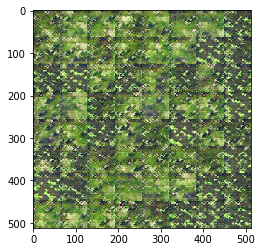

In [4]:
'''
Обучение модели.
Не трогать ячейку, если просто хочешь загрузить обученную модель.
'''
if FLAGS.train:
    dcgan.train(FLAGS)

### 2.2 Обучение на выборке сотавленной из нарезанных на более мелкие изображения эталонных паттернов

Так как данная выборка содержит ~ 7000 изображений, то количество эпох для обучения было решено взять равным 25. Обученние продлились около 4.5 часов на ноутбуке с процессором Core i5-4200U 2.30 ГГц и графическим процессором Nvidia GeForce GT 730M.

Посмотрим тенденцию обучения генеративной сети между разными эпохами. Так менялся выход генеративной сети с 1 по 5 эпоху:

***Изображения представляют из себя композицию 64 сгенерированных изображений 64х64 пикселей составляющих изображение 512х512 пикселей.***

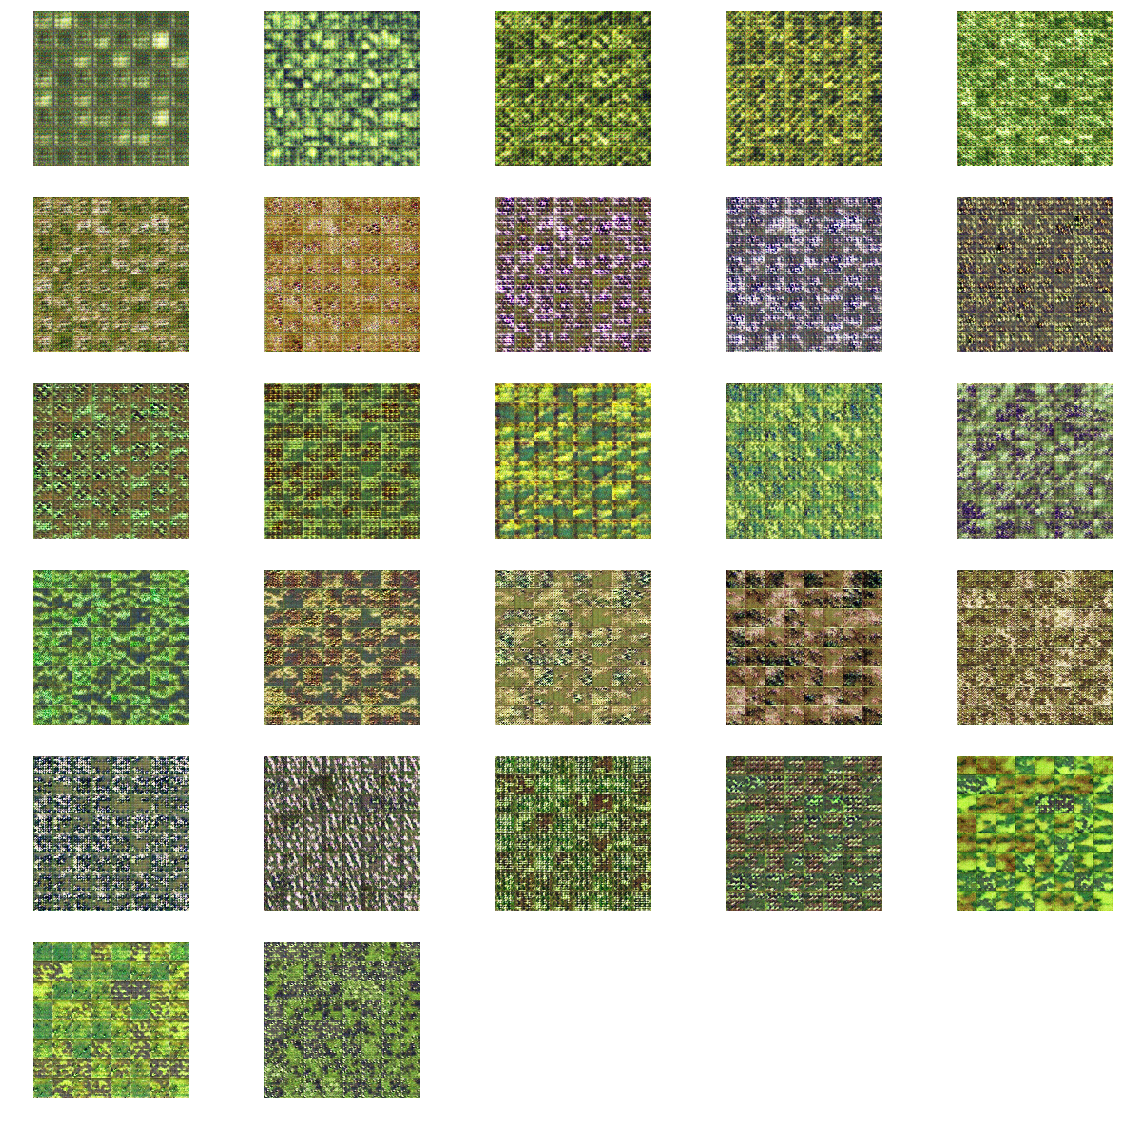

In [11]:
utils.show_images_fullsize(image_paths=glob('./samples/test2/train_[0-2]*.png'))

Продолжим эксперименты с моделью, обученной на данной выборке.

## 3. Распознавание генерируемого камуфляжа

Загрузим обученную генертивную модель.

In [5]:
'''
Загрузить модель, обученную на предыущем  шаге.
'''
if not dcgan.load(FLAGS.checkpoint_dir)[0]:
    raise Exception("[!] Train a model first, then run test mode")

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint\camoflage_test3_64_64_64\DCGAN.model-2727
 [*] Success to read DCGAN.model-2727


### 3.1 Распознавание  первой моделью
После того как мы обучили модель, можно приступить к экспериментам с распознаванием генирируемого камуфляжа. Распознавание будет проводиться уже обученными моделями нейронных сетей.

1. RCNN обученная на <a href='http://www.image-net.org/challenges/LSVRC/2013/'>ILSVRC2013</a> взята из https://github.com/BVLC/caffe
>*Rich feature hierarchies for accurate object detection and semantic segmentation. Ross Girshick, Jeff Donahue, Trevor Darrell, Jitendra Malik. CVPR 2014.* [Arxiv 2014](http://arxiv.org/abs/1311.2524).

В качестве тестового набора будет выступать набор изображений людей в камуфляже, которые все модели гарантированно полностью распознают. 

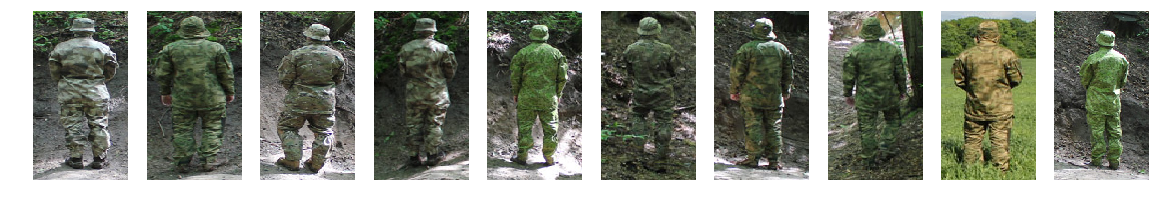

In [6]:
utils.show_images_fullsize(image_paths=glob('./data/person/person_sample/*.*g'),columns=10)

### 3.2 RCNN обученая на ILSVRC2013

Для начала проверим распознает ли нейронная сеть все изображения людей 

In [5]:
rcnn.classify_batch(glob('./data/person/person_sample/*.*g'))

CaffeNet found.
Изображение-1 --- Распознанный класс:  123 n00007846 person
Изображение-2 --- Распознанный класс:  123 n00007846 person
Изображение-3 --- Распознанный класс:  123 n00007846 person
Изображение-4 --- Распознанный класс:  123 n00007846 person
Изображение-5 --- Распознанный класс:  123 n00007846 person
Изображение-6 --- Распознанный класс:  123 n00007846 person
Изображение-7 --- Распознанный класс:  123 n00007846 person
Изображение-8 --- Распознанный класс:  123 n00007846 person
Изображение-9 --- Распознанный класс:  123 n00007846 person
Изображение-10 --- Распознанный класс:  123 n00007846 person
Распознанно 10 из 10 (100.0%)


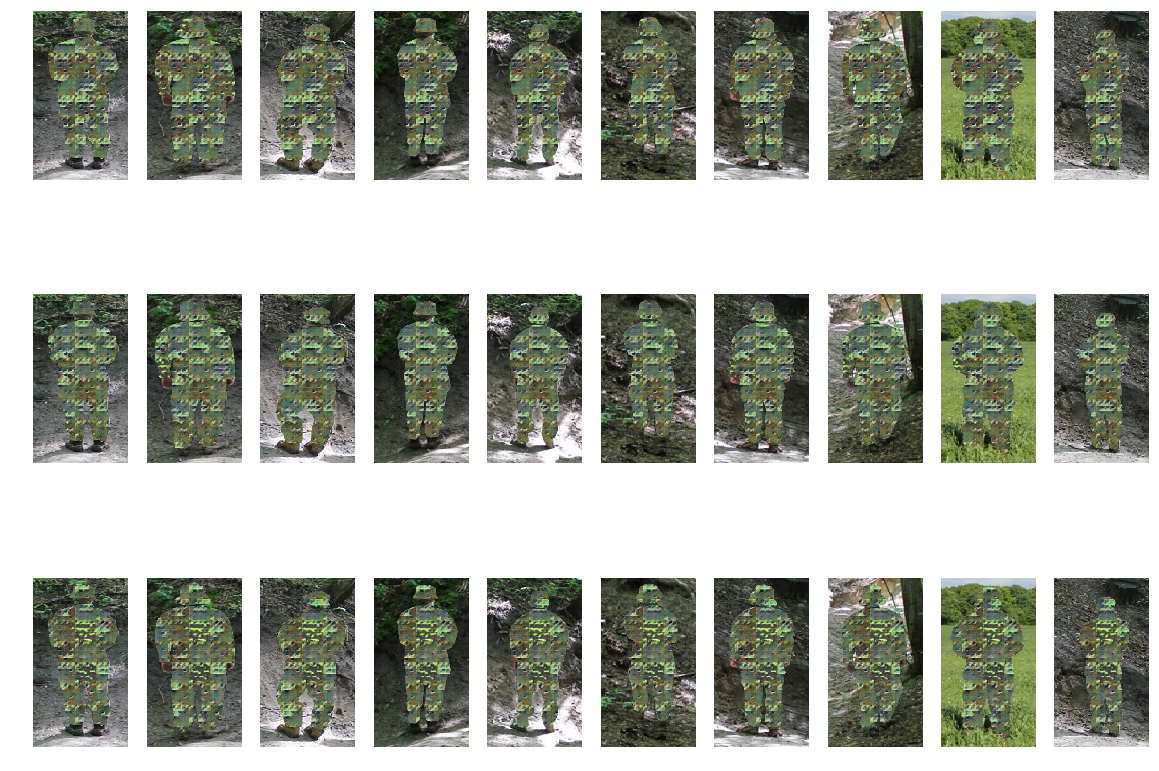

In [7]:
utils.generate_camo_person(dcgan.sess, dcgan, FLAGS,3)

In [10]:
rcnn.classify_batch(glob('./samples/generated_camo_person/person*.png'))

CaffeNet found.
Изображение-1 --- Распознанный класс:  195 n04557648 water bottle
Изображение-2 --- Распознанный класс:  67 n03991062 flower pot
Изображение-3 --- Распознанный класс:  52 n07718472 cucumber
Изображение-4 --- Распознанный класс:  52 n07718472 cucumber
Изображение-5 --- Распознанный класс:  195 n04557648 water bottle
Изображение-6 --- Распознанный класс:  195 n04557648 water bottle
Изображение-7 --- Распознанный класс:  195 n04557648 water bottle
Изображение-8 --- Распознанный класс:  195 n04557648 water bottle
Изображение-9 --- Распознанный класс:  67 n03991062 flower pot
Изображение-10 --- Распознанный класс:  28 n02879718 bow
Изображение-11 --- Распознанный класс:  195 n04557648 water bottle
Изображение-12 --- Распознанный класс:  195 n04557648 water bottle
Изображение-13 --- Распознанный класс:  67 n03991062 flower pot
Изображение-14 --- Распознанный класс:  67 n03991062 flower pot
Изображение-15 --- Распознанный класс:  52 n07718472 cucumber
Изображение-16 --- Распоз

In [2]:
import utils
from glob import glob
import scipy.misc
from matplotlib.pyplot import imshow
import os
data_dir = './data'

image_paths=glob(os.path.join(data_dir, 'camo_patterns/test1/[0-9].*g'))
avg_camo = utils.image_avg_sum(image_paths)
imshow(avg_camo)
scipy.misc.imsave('./samples/generated_camo_person/avrg_camo.png',avg_camo)

In [3]:
utils.pattern_camo_person(avg_camo)

In [4]:
image_paths

['./data\\camo_patterns/test1\\0.jpg',
 './data\\camo_patterns/test1\\1.jpg',
 './data\\camo_patterns/test1\\2.jpg',
 './data\\camo_patterns/test1\\3.jpg',
 './data\\camo_patterns/test1\\4.jpg']

In [19]:
rcnn.classify_batch(glob('./samples/generated_camo_person/person_avrg*.png'))

CaffeNet found.
Изображение-1 --- Распознанный класс:  123 n00007846 person
Изображение-2 --- Распознанный класс:  123 n00007846 person
Изображение-3 --- Распознанный класс:  7 n02764044 axe
Изображение-4 --- Распознанный класс:  123 n00007846 person
Изображение-5 --- Распознанный класс:  123 n00007846 person
Изображение-6 --- Распознанный класс:  171 n04336792 stretcher
Изображение-7 --- Распознанный класс:  123 n00007846 person
Изображение-8 --- Распознанный класс:  123 n00007846 person
Изображение-9 --- Распознанный класс:  63 n02503517 elephant
Изображение-10 --- Распознанный класс:  164 n04270147 spatula
Распознанно 6 из 10 (60.0%)
